In [1]:
import sys
import os
from pathlib import Path
from hydra import initialize, compose
initialize(config_path="../confs", job_name="notebook")

sys.path.append(os.path.abspath("../src"))
# We change the working directory to the root of the project
# Run this only once
root_path = Path.cwd().parent
os.chdir(root_path)
sys.path.append(root_path / "src")

/tmp/ipykernel_73722/1901343020.py:5: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../confs", job_name="notebook")


In [2]:
from src.utils import torch_to_pil
from src.character_linking.feature_matching import featureMatching
from src.character_linking.params import HOGParameters, featureMatchingParameters, fullHOGOutput, featureMatchingOutputs
from src.utils import connectedComponent
from src.patch_processing.patch_extraction import extract_patches

from notebook_utils.viz import show_random_sample
from notebook_utils.descriptor import compute_hog, visualize_hog
from einops import rearrange
import torch

import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

from PIL import Image

image_folder = Path('data/datasets/book1')
# comps_folder = Path('data/extracted/book1-complete/components/')
comps_folder = Path('tests/book1-complete/components/')


assert image_folder.exists()
assert comps_folder.exists()
files = next(os.walk(image_folder))[2]

# Pipeline

This notebook presents the pipeline used to preprocess the images and compute character-wise features. We:

1. Preprocess the images using the Binary Vectorization Method by He. et al
2. Render them into a grid, aligning the barycenters with the middle of the canvas
3. Compute their Histogram of Oriented Gradients (HOG)
4. Predict the character using EasyOCR's Traditional Chinese OCR
5. Describe the meaning of the character using ChatGPT

---

# Part one: Pre-processing

We begin by extracting image patches of individual characters from the source book and applying a series of pre-processing steps. First, the patches are vectorized using **Binary Shape Vectorization by Affine Scale-Space**, a method developed by Yuchen He.

This technique converts binary input images into smooth SVG representations composed of Bézier curves. As a result, we obtain cleaner and smoother hànzì shapes, free from noise and JPEG compression artifacts.

Subsequently, we render them at a higher resolution and apply additional filtering steps to remove ink defects and spurious artifacts within the character shapes.

We now proceed by extracting the character patches and their corresponding binarized images from the document. Note that the binarized images are directly taken from the outputs of the hànzì extraction notebook. Regions predicted as not belonging to the actual character are excluded from the displayed patches.


100%|██████████| 38/38 [00:48<00:00,  1.27s/it]


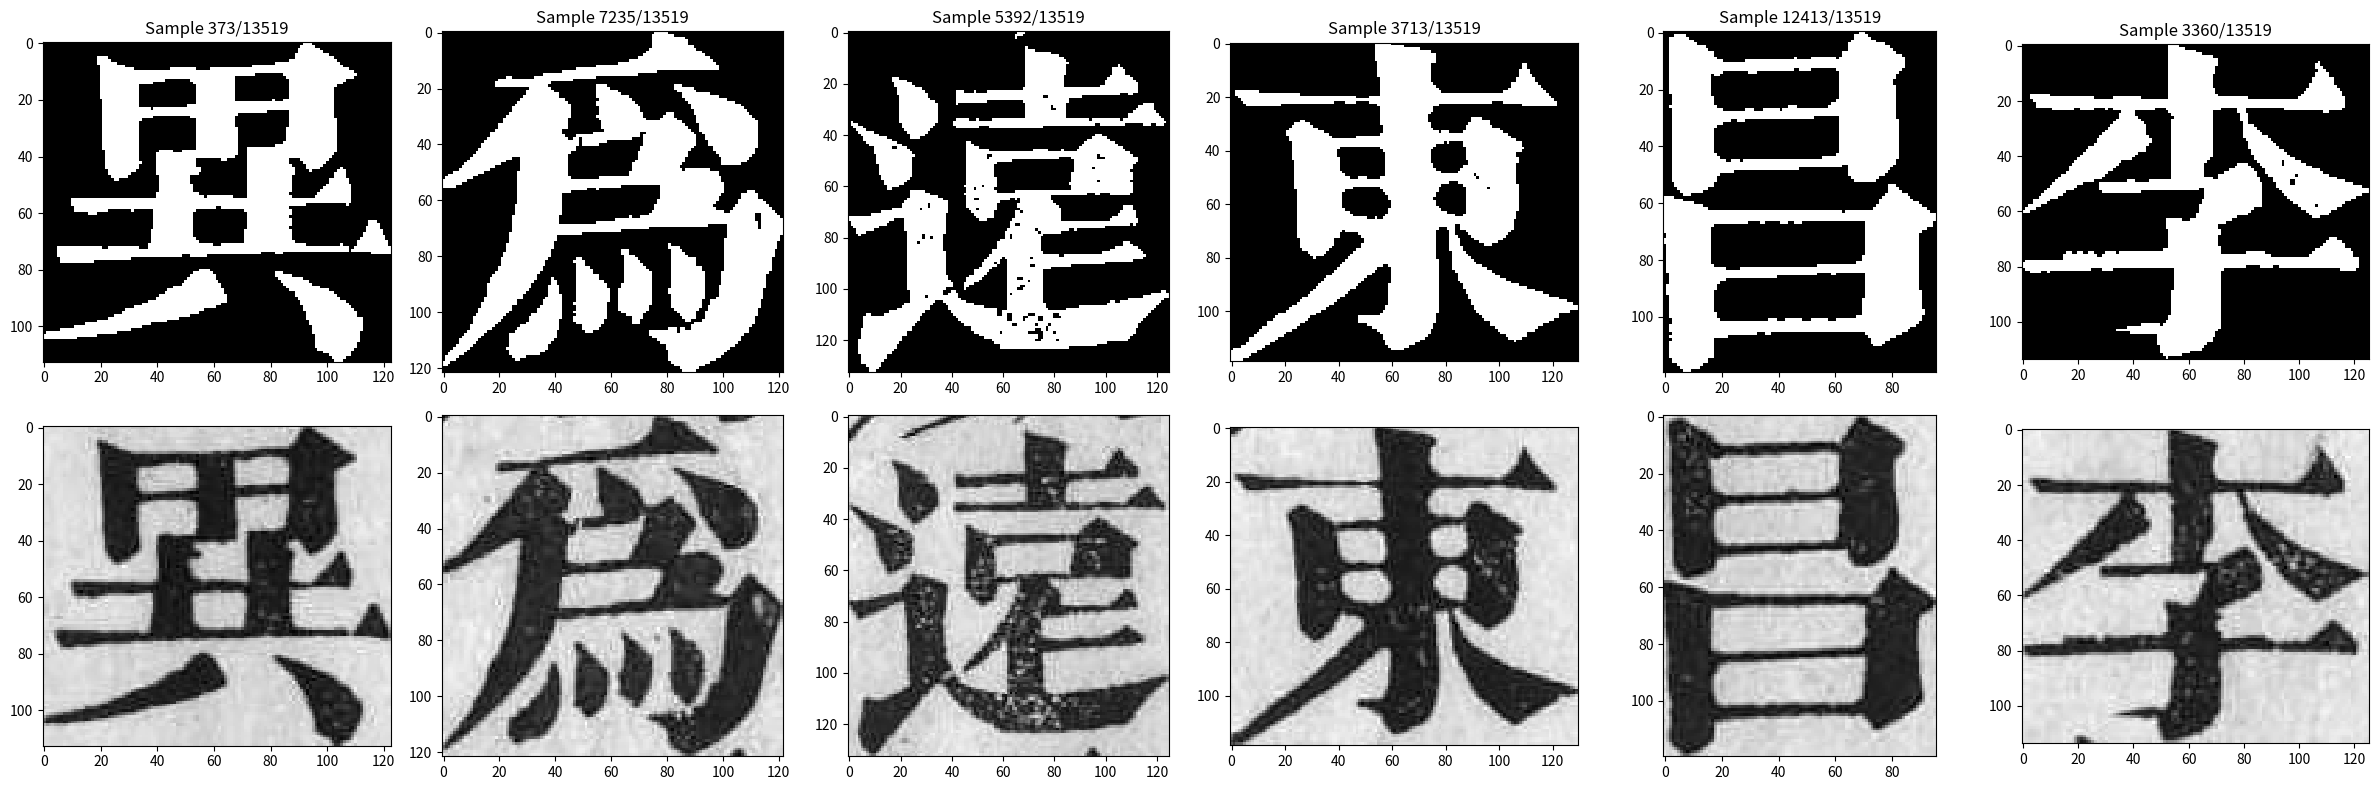

In [3]:
patches_df = pd.DataFrame(columns=['bin_patch', 'img_patch', 'page', 'file', 'left', 'top', 'width', 'height'])

# Main loop
for i, file in tqdm.tqdm(list(enumerate(files))):
    
    
    # Load the image / components
    img_np = np.array(Image.open(image_folder / file))
    img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)[..., None]
    # img_torch = torch.tensor(img_np, device=patches_device, dtype=patches_dtype).permute(2,0,1).float() / 255
    # img_torch.requires_grad = False
    img_comp = connectedComponent.load(comps_folder / (str(file) + '.npz'))
    img_comp._stats = img_comp._compute_stats_from_labels(img_comp._labels)
    
    _bin_patches, _img_patches = extract_patches(
        characterComponents=img_comp,
        images = [img_np],
        return_bin=True
    )


    stats = img_comp.stats[1:]

    page_df = pd.DataFrame({
        'bin_patch': _bin_patches,
        'img_patch': _img_patches,
        'page': i,
        'file': file,
        'left': stats[:,0],
        'top': stats[:, 1],
        'width': stats[:,2],
        'height': stats[:, 3]
    })
    
    # Concatenate immediately
    patches_df = pd.concat([patches_df, page_df], ignore_index=True)


                    
show_random_sample(patches_df['bin_patch'], patches_df['img_patch'], n_samples=6)

100%|██████████| 13519/13519 [00:18<00:00, 715.68it/s]


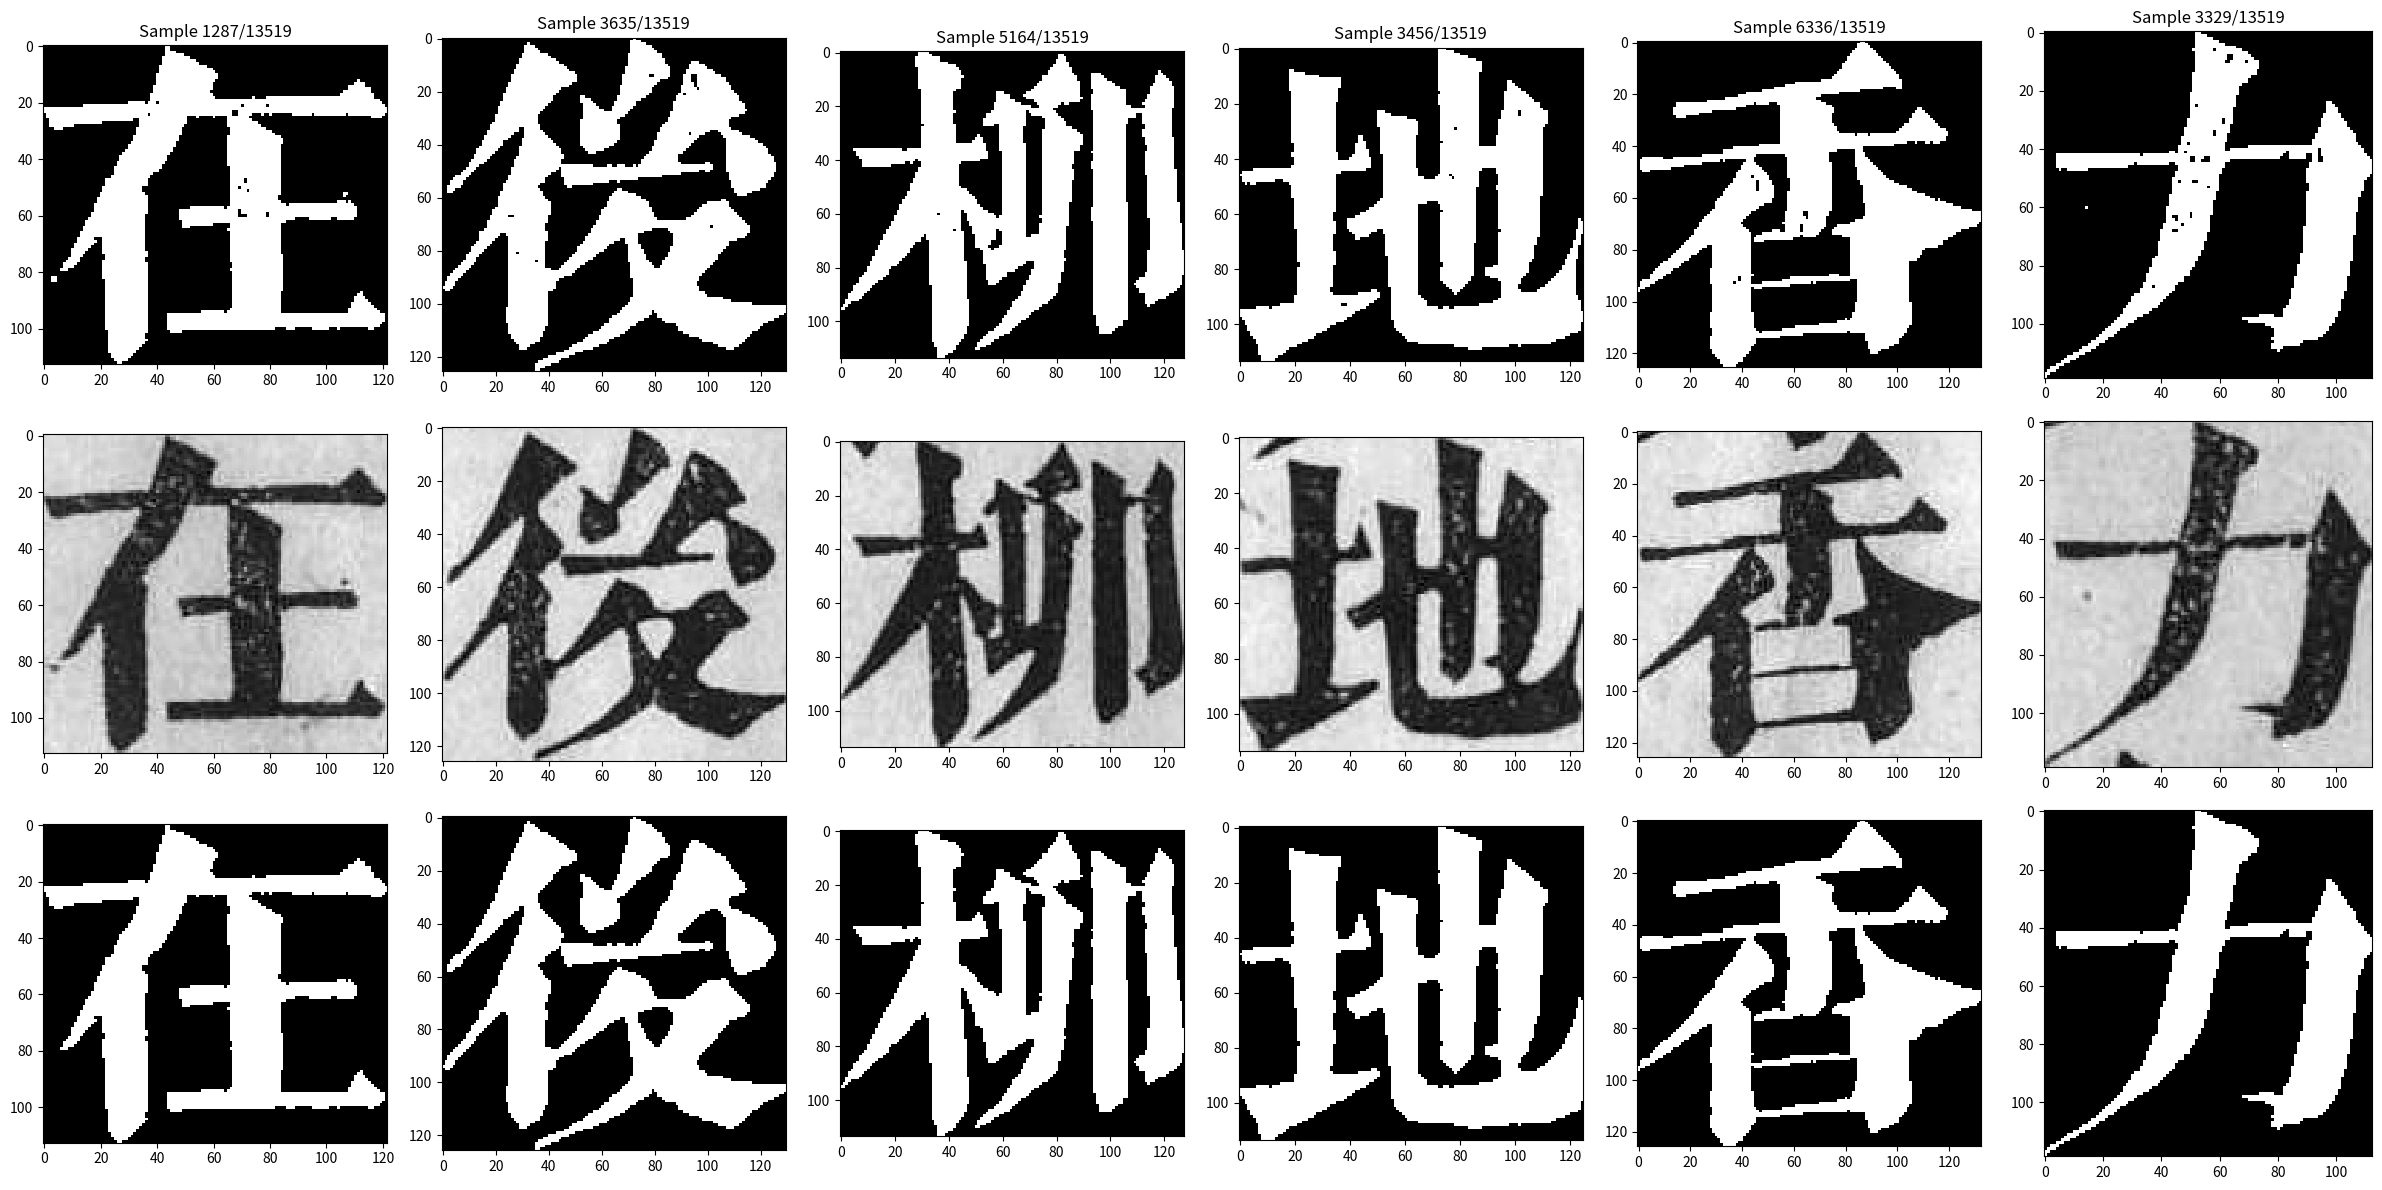

In [4]:
filtered_images = []

from src.patch_processing import filter_binary_patch

dpi = 256
scale = 1
min_size_black=75*scale**2,
min_size_white=20*scale**2,


N = 60


for bin_patch in tqdm.tqdm(patches_df['bin_patch']):

    #? Filter
    filtered = filter_binary_patch(
        bin_patch, 
        min_size_black=min_size_black, 
        min_size_white=min_size_white, 
    )
    
    filtered_images.append(filtered)


patches_df['filtered_bin_patch'] = filtered_images

show_random_sample(patches_df['bin_patch'], patches_df['img_patch'], patches_df['filtered_bin_patch'], n_samples=6)

**We now proceed to vectorizing the hànzi**

In [6]:
from IPython.display import display, Markdown
from hydra.utils import instantiate
from operator import itemgetter
from omegaconf import OmegaConf
from src.patch_processing.normalization import compute_normalization_homography, compute_svg_normalization_homography
from src.patch_processing import filter_binary_patch
from IPython.display import SVG as IPYSVG
from tqdm import tqdm
os.environ["HYDRA_FULL_ERROR"] = "1"


# ==== Instantiate the vectorizer ====

#? See configs/vectorizer.yaml
cfg = compose(config_name="vectorizer")
vect = instantiate(cfg)

#? We show the content of the config 
display(Markdown(f"```yaml\n{OmegaConf.to_yaml(cfg)}\n```"))



#! ==== CACHING ====

if False:
    svg_imgs = []
    for i in tqdm(range(len(patches_df)), desc="Loading vectorized images", unit="img", colour='green'):
        svg_imgs.append(SVG.load(Path(cfg.config.save_dir) / f'output_{i:06d}.svg'))

#! ==== Vectorize the images ===

else:
    inverted = [p<.5 for p in patches_df['filtered_bin_patch']]
    svg_imgs = []
    for svg in tqdm(vect(inverted), total=len(inverted), desc="Vectorizing images", unit="img", colour='green'): # <-- iterator over the images | gathers data in parallel and yields it
        svg_imgs.append(svg)

    del inverted # free some memory

    svg_imgs = sorted(svg_imgs, key=itemgetter(0))
    svg_imgs = [el[1] for el in svg_imgs]



# ==== Compute the bboxes of every SVG image ===

bboxes = []
for svg_object in tqdm(svg_imgs, desc="Computing bounding boxes", unit="svg", colour='blue'):
    bboxes.append(svg_object._compute_bbox())

bboxes = np.array(bboxes)
aspect_ratio = bboxes[:, 2] / bboxes[:, 3]

print('Image with max aspect ratio: ', np.maximum(aspect_ratio, 1/aspect_ratio).argmax())

# ==== Align the SVGs ====
# Not used at the moment
# We found that it did not really work well.

# from src.patch_processing.normalization import process_svg

# #? Show two examples for demo purposes
# scale = 4

# i = np.random.randint(0, len(svg_imgs))
# print(f'Visualizing index {i}')
# idx, svg_object = svg_imgs[i]
# process_svg(image=img_patches[idx], svg_object=svg_object, display=True, scale=scale)
# i = np.random.randint(0, len(svg_imgs))
# print(f'Visualizing index {i}')
# idx, svg_object = svg_imgs[i]
# process_svg(image=img_patches[idx], svg_object=svg_object, display=True, scale=scale)

# #! Process the rest
# scale = 1
# for i, (idx, svg_object) in enumerate(tqdm(svg_imgs, desc="Processing & saving SVGs", unit="svg", colour='magenta')):
#     process_svg(image=img_patches[idx], svg_object=svg_object, display=False, scale=scale)
#     svg_object.save(f'output_svg_aligned/output_{i:06d}.svg')

2026-01-04 22:58:35,592 - INFO - Initialized vectorizer:
2026-01-04 22:58:35,592 - INFO -   output_size: (512, 512)
2026-01-04 22:58:35,593 - INFO -   background_color: (255, 255, 255, 255)
2026-01-04 22:58:35,593 - INFO -   output_format: L


```yaml
_target_: src.vectorization.BinaryShapeVectorizer
config:
  _target_: src.vectorization.VectorizerConfig
  executable_path: ./build/main
  smoothing_scale: 1
  accuracy_threshold: 1
  refinement_iterations: 0
  output_type: shape_merged
  return_svg: true
  return_svg_string: false
  return_rendered: false
  save_dir: ./outputs_svg
  output_size:
  - 512
  - 512
  background_color:
  - 255
  - 255
  - 255
  - 255
  dpi: 2048
  scale: 1.0
  output_format: L
  n_jobs: -1
  show_progress: true
  chunk_size: 100
  stream_results: true
  stream_parallel: true

```

2026-01-04 22:58:35,864 - INFO - Processing 13519 binarized images
2026-01-04 22:58:35,865 - INFO - First image shape: (108, 130), dtype: bool
Computing bounding boxes: 100%|██████████| 13519/13519 [00:00<00:00, 50993.60svg/s]

Image with max aspect ratio:  7736


Maximum aspect ratio:  SVG(127.9×23.8, 1 paths, original_viewbox=(0.0, 0.0, 123.0, 41.0))


With the biggest width: SVG(150.9×120.9, 1 paths, original_viewbox=(0.0, 0.0, 126.0, 116.0))


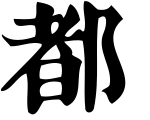

In [7]:
patches_df['svg'] = svg_imgs
aspect_ratio = patches_df['width'] / patches_df['height']
patches_df['aspect_ratio'] = aspect_ratio
i_max = np.maximum(aspect_ratio, 1/aspect_ratio).argmax()
print('Maximum aspect ratio: ',patches_df['svg'][i_max] )
patches_df['svg'][i_max].render_svg()

i_max = bboxes[:, 2].argmax()
print('With the biggest width:', patches_df['svg'][i_max])
patches_df['svg'][i_max].render_svg()

In [8]:
patches_df['svg_str'] = patches_df['svg'].map(lambda x: x.to_string())

Rendering: 100%|██████████| 60/60 [00:00<00:00, 147.54img/s]


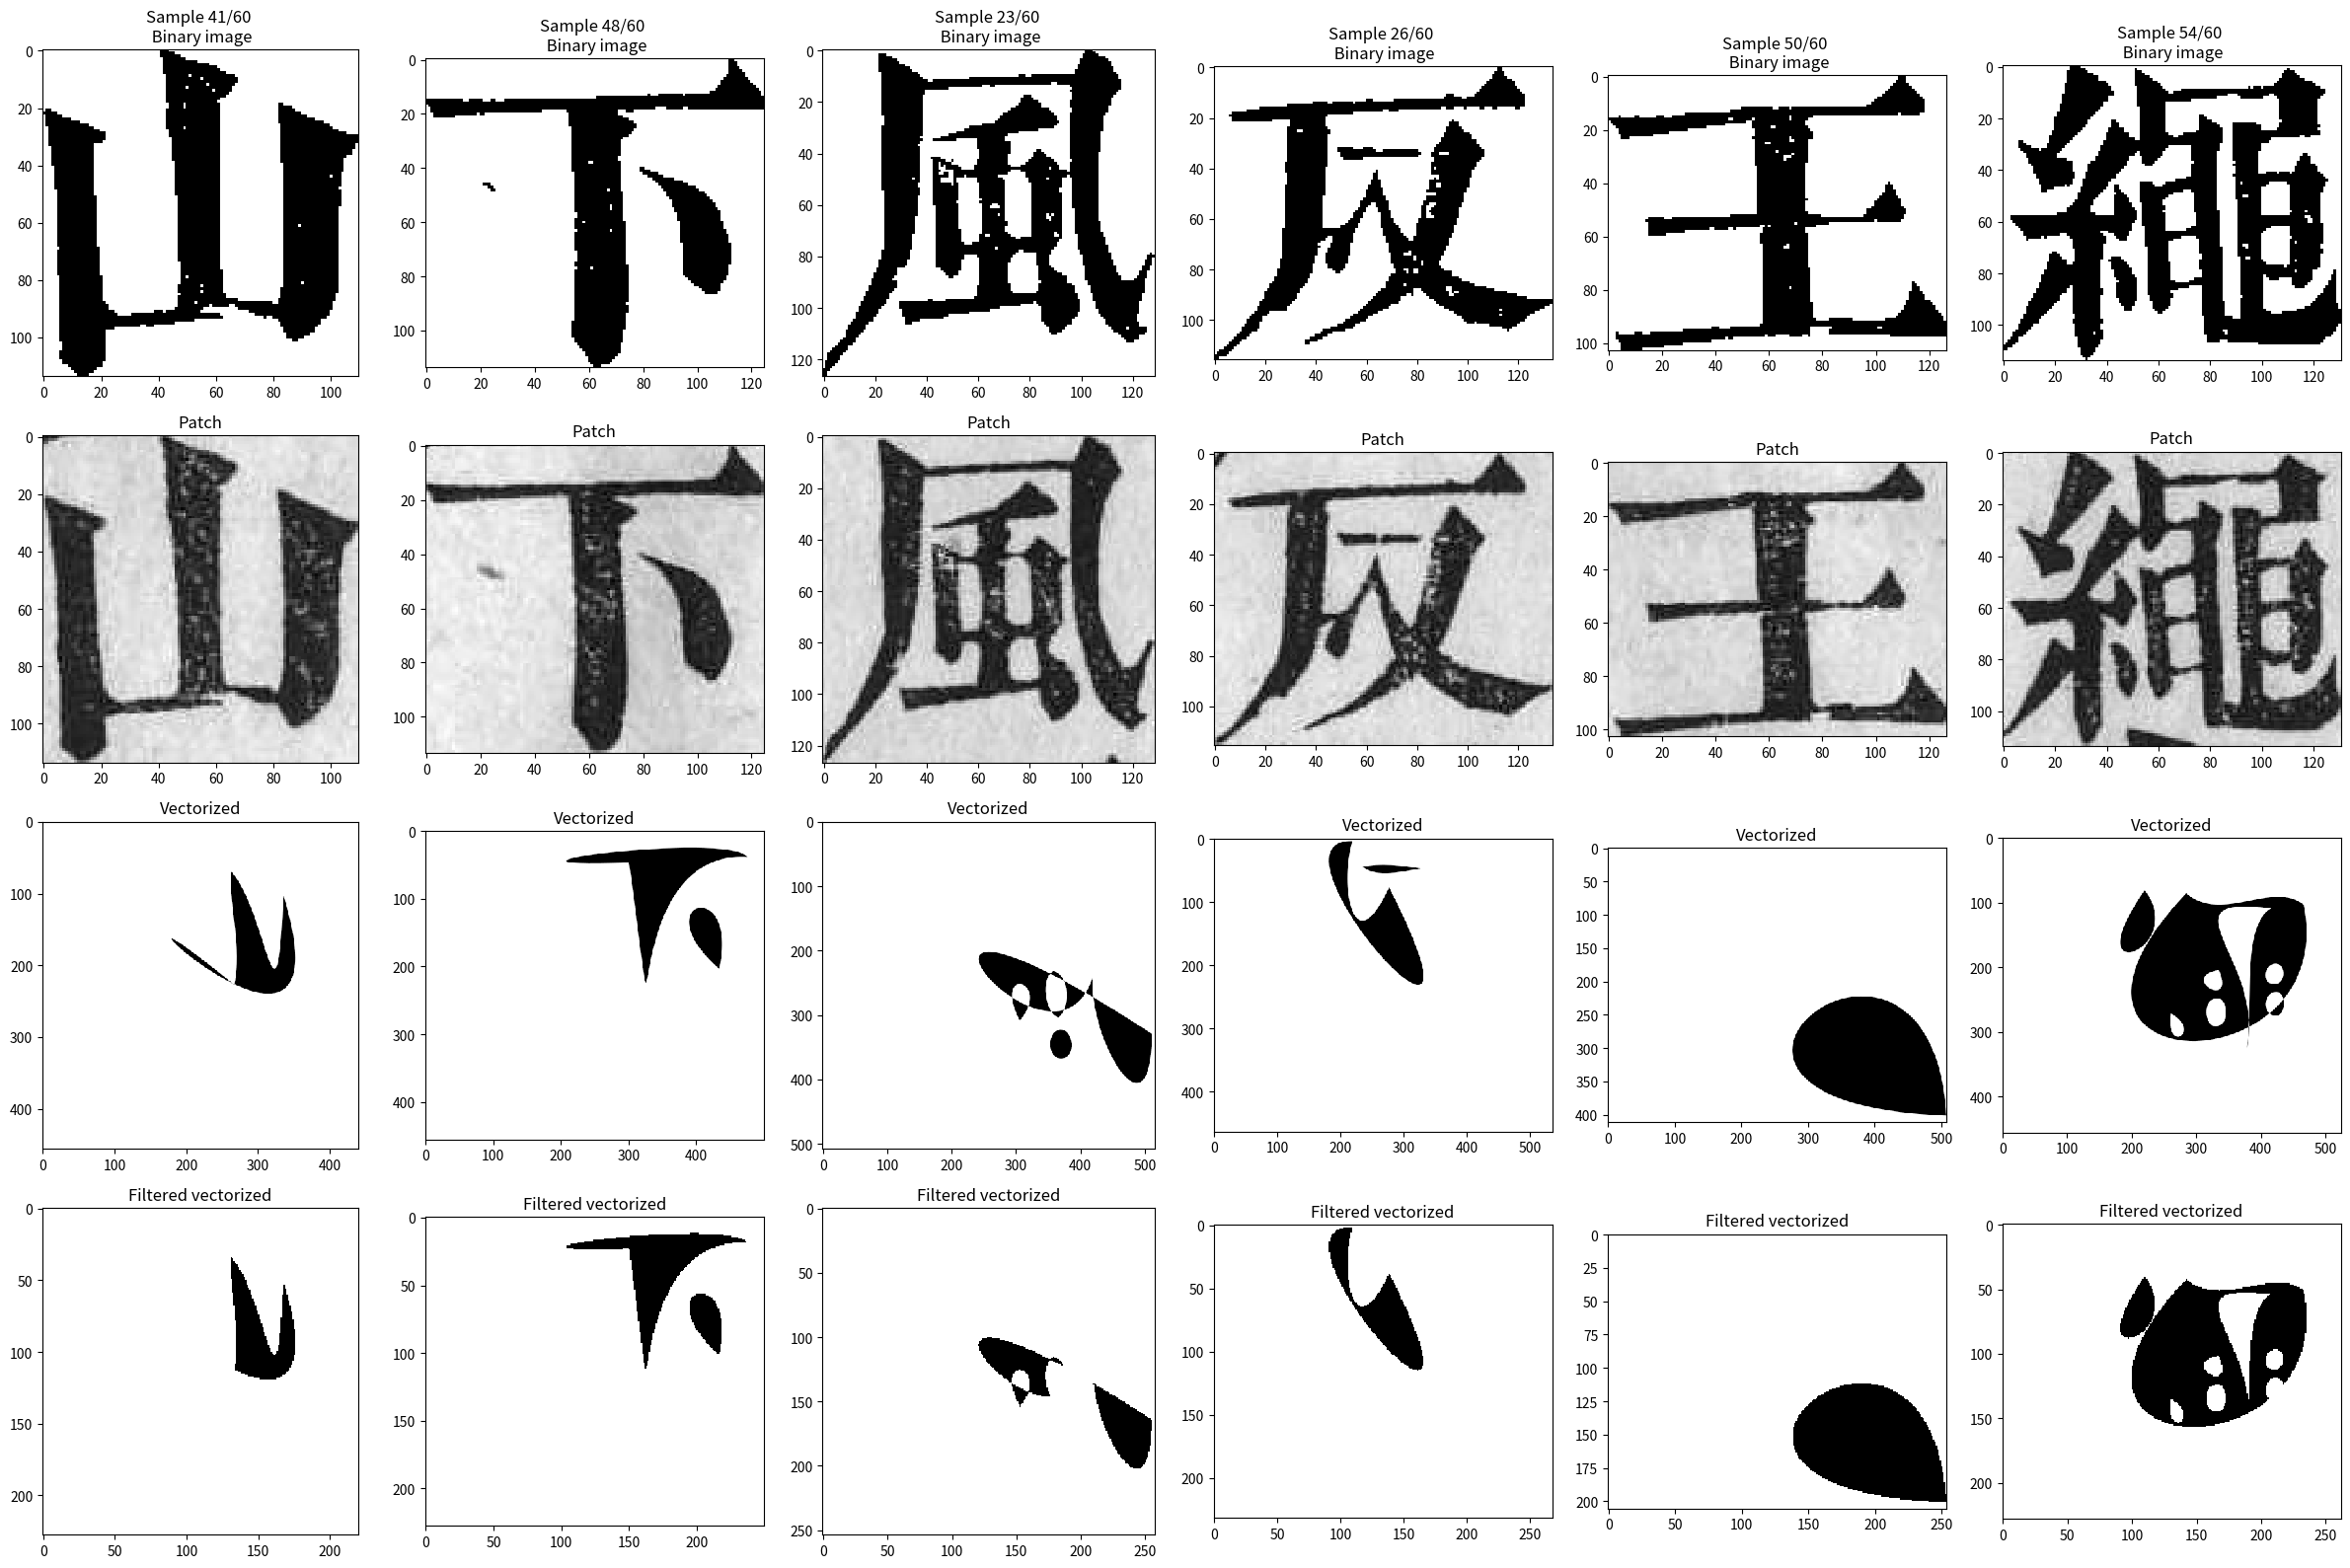

In [ ]:
filtered_images = []

dpi = 256
scale = 2
min_size_black=75*scale**2,
min_size_white=20*scale**2,


N = 60


for svg_object in tqdm(patches_df['svg'][:N], desc="Rendering", unit="img"):

    #? Render
    svg_rendered = svg_object.render(
        dpi=dpi, 
        output_format='L', 
        scale=scale,
    )
    
    #? Binarize
    binary_svg = svg_rendered > 128
    
    #? Filter
    filtered = filter_binary_patch(
        binary_svg, 
        min_size_black=min_size_black, 
        min_size_white=min_size_white, 
    )
    
    filtered_images.append(filtered)


show_random_sample(~patches_df['bin_patch'][:N], patches_df['img_patch'][:N], patches_df['svg'][:N], filtered_images[:N], n_samples=6, scale=4, titles=['Binary image', 'Patch', 'Vectorized', 'Filtered vectorized'])

<Axes: >

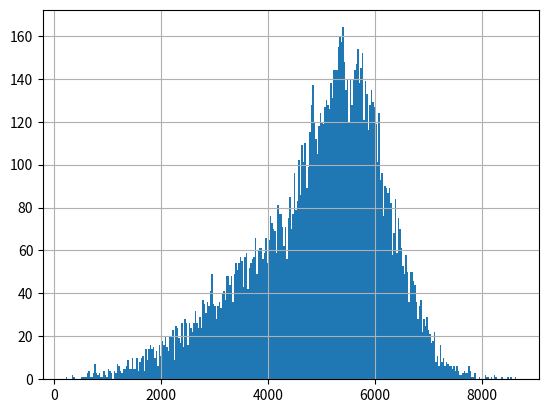

In [9]:
patches_df['bin_patch'].map(lambda x: x.sum()).hist(bins=300)

In [ ]:
def show_row(row, highlights=None, all=False):

    file = files[row['page']]
    img_np = np.array(Image.open(image_folder / file))
    print(img_np.shape)

    
    
    # Draw rectangle on a copy of the image
    img_with_rect = img_np.copy()
    page_number = patches_df['page'][i]
    if all:
        selection = patches_df[patches_df['page'] == page_number]
        for _, row in selection.iterrows():
            left, top, w, h = row[['left', 'top', 'width', 'height']]
            cv2.rectangle(img_with_rect, (left, top), (left+w, top+h), (255, 185, 64), 8)


    if highlights is not None:

        selection = patches_df.iloc[highlights]
        selection = selection[selection['page'] == page_number]

        for _, row in selection.iterrows():
            left, top, w, h = row[['left', 'top', 'width', 'height']]
            cv2.rectangle(img_with_rect, (left, top), (left+w, top+h), (0, 255, 0), 8)

    left, top, w, h = row[['left', 'top', 'width', 'height']]
    cv2.rectangle(img_with_rect, (left, top), (left+w, top+h), (255, 0, 0), 8)


    # Display the image with rectangle
    plt.figure(figsize=(16,9))
    plt.imshow(img_with_rect)
    plt.title(f"Page: {row['page']}, Position: ({left}, {top}) ; filename: {file}")
    plt.axis('off')
    plt.show()




In [ ]:
from src.patch_processing.normalization import compute_moment
from src.patch_processing import filter_binary_patch
from torch.utils.data import Dataset


class Renderer(Dataset):
    """Renders SVG images centered on their barycenters."""
    
    def __init__(
        self,
        svg_imgs,
        min_size_black,
        min_size_white,
        scale,
        bin_thresh=128,
        dpi=64,
        tqdm=True,
        pad_to_multiple=None
    ):
        self.svg_imgs = list(svg_imgs)
        self.min_size_black = min_size_black
        self.min_size_white = min_size_white
        self.scale = scale
        self.bin_thresh = bin_thresh
        self.dpi = dpi
        self.use_tqdm = tqdm
        self.pad_to_multiple = pad_to_multiple
        
        # Precompute canvas dimensions
        self._precompute_canvas()

        print(f'Canvas dimensions: w={self.canvas_width}, h={self.canvas_height}, cx={self.center_x}, cy={self.center_y}')
    
    def _precompute_canvas(self):
        """Compute canvas dimensions and barycenters once."""
        from tqdm import tqdm
        
        shapes, barycenters = self.compute_barycenters(svg_imgs)
        extents = self.compute_extents(shapes, barycenters)
        self.canvas_dims = self.compute_canvas_dims(extents)
        self.barycenters = barycenters
        
        self.canvas_width, self.canvas_height, self.center_x, self.center_y = self.canvas_dims
    
    def filter_images(self, svg_imgs):
        """Returns an iterator of filtered images."""
        from tqdm import tqdm
        
        it = tqdm(svg_imgs, desc="Rendering", unit="img") if self.use_tqdm else svg_imgs

        for svg_object in it:
            svg_rendered = svg_object.render(
                dpi=self.dpi, 
                output_format='L', 
                scale=self.scale,
                output_size=None
            )
            
            binary_svg = svg_rendered < self.bin_thresh
            
            filtered = filter_binary_patch(
                binary_svg, 
                min_size_black=self.min_size_black, 
                min_size_white=self.min_size_white, 
            )
            
            yield filtered

    def compute_barycenters(self, svg_imgs):
        barycenters = []
        shapes = []

        for filtered in self.filter_images(svg_imgs):
            m00 = compute_moment(filtered, 0, 0)
            if m00 == 0:
                cy, cx = filtered.shape[0] // 2, filtered.shape[1] // 2
            else:
                cy = compute_moment(filtered, 1, 0) / m00
                cx = compute_moment(filtered, 0, 1) / m00
            
            h, w = filtered.shape
            cy_pixel = (cy + 1) * (h - 1) / 2
            cx_pixel = (cx + 1) * (w - 1) / 2

            barycenters.append((cy_pixel, cx_pixel))
            shapes.append((h, w))

        return shapes, barycenters

    def compute_extents(self, shapes, barycenters):
        extents = []
        for (h, w), (cy, cx) in zip(shapes, barycenters):
            left = cx
            right = w - cx
            top = cy
            bottom = h - cy
            
            extents.append({
                'left': left,
                'right': right,
                'top': top,
                'bottom': bottom
            })
        return extents

    def _round_up_to_multiple(self, value, multiple):
        if multiple is None or multiple <= 1:
            return value
        return int(np.ceil(value / multiple) * multiple)

    def compute_canvas_dims(self, extents):
        max_left = max(e['left'] for e in extents)
        max_right = max(e['right'] for e in extents)
        max_top = max(e['top'] for e in extents)
        max_bottom = max(e['bottom'] for e in extents)
        
        canvas_width = int(np.ceil(max_left)) + int(np.ceil(max_right))
        canvas_height = int(np.ceil(max_top)) + int(np.ceil(max_bottom))

        if self.pad_to_multiple is not None and self.pad_to_multiple > 1:
            new_width = self._round_up_to_multiple(canvas_width, self.pad_to_multiple)
            new_height = self._round_up_to_multiple(canvas_height, self.pad_to_multiple)
            
            pad_x = new_width - canvas_width
            pad_y = new_height - canvas_height
            
            pad_left = pad_x // 2
            pad_top = pad_y // 2
            
            canvas_width = new_width
            canvas_height = new_height
        else:
            pad_left = 0
            pad_top = 0

        center_x = int(np.ceil(max_left)) + pad_left
        center_y = int(np.ceil(max_top)) + pad_top
        
        return canvas_width, canvas_height, center_x, center_y
    
    def __len__(self):
        return len(self.svg_imgs)
    
    def __getitem__(self, idx):
        """Get a single rendered image by index."""
        svg_object = self.svg_imgs[idx]
        
        # Render and filter
        svg_rendered = svg_object.render(
            dpi=self.dpi, 
            output_format='L', 
            scale=self.scale,
            output_size=None
        )
        
        binary_svg = svg_rendered < self.bin_thresh
        
        filtered = filter_binary_patch(
            binary_svg, 
            min_size_black=self.min_size_black, 
            min_size_white=self.min_size_white, 
        )
        
        # Paste on canvas
        cy, cx = self.barycenters[idx]
        h, w = filtered.shape
        start_y = int(np.round(self.center_y - cy))
        start_x = int(np.round(self.center_x - cx))
        
        canvas_img = np.zeros((self.canvas_height, self.canvas_width))
        canvas_img[start_y:start_y+h, start_x:start_x+w] = filtered
        
        # Convert to tensor
        return torch.from_numpy(canvas_img).float()


# Usage
dpi = 256
scale = 1
min_size_black = 75 * scale**2
min_size_white = 20 * scale**2

dataset = Renderer(
    svg_imgs=svg_imgs,
    min_size_black=min_size_black,
    min_size_white=min_size_white,
    scale=scale,
    bin_thresh=128,
    dpi=dpi,
    pad_to_multiple=32
)

# Access canvas dimensions
canvas_width = dataset.canvas_width
canvas_height = dataset.canvas_height
center_x = dataset.center_x
center_y = dataset.center_y

print(f"Canvas size: {canvas_width}×{canvas_height} pixels")

# Create DataLoader for batching
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset,
    batch_size=256,
    shuffle=False,
    num_workers=0,  # Set to >0 if rendering is CPU-intensive
    pin_memory=True
)


# Or get individual images
N = 10
fig, axes = plt.subplots(N, N, figsize=(24, 24), constrained_layout=True)

for i, ax in enumerate(axes.flat):
    ax.axis('off')
    
    img = dataset[i].numpy()  # Get i-th image
    ax.imshow(img, cmap='gray', vmin=0, vmax=1, aspect='equal')
    ax.set_title(f'Image {i}', fontsize=10)
    
    ax.plot(center_x, center_y, 'r+', markersize=10, markeredgewidth=1.5)

plt.show()


Rendering: 100%|██████████| 13519/13519 [00:39<00:00, 340.11img/s]


Canvas dimensions: w=4128, h=2784, cx=4011, cy=2659
Canvas size: 4128×2784 pixels


In [10]:
import easyocr
import numpy as np
from tqdm import tqdm

reader = easyocr.Reader(['ch_tra'], gpu=True, verbose=False)

print("Processing OCR...")
all_results = []

for idx in tqdm(range(len(patches_df)), desc="OCR Processing"):
    patch = patches_df['svg'].iloc[idx].render(output_format='RGB')
    if patch.dtype != np.uint8:
        patch = patch.astype(np.uint8)
    
    try:
        result = reader.readtext(patch, detail=0)
        all_results.append(result[0] if result else '')
    except:
        all_results.append('')

patches_df['predicted_char'] = all_results

del reader

Processing OCR...


OCR Processing: 100%|██████████| 13519/13519 [11:28<00:00, 19.64it/s]


In [11]:
from notebook_utils.parquet_utils import save_dataframe
save_dataframe(patches_df.drop(columns='svg'), 'data/tmp/svg')

Saving column: bin_patch
Saving column: img_patch
Saving column: page
Saving column: file
Saving column: left
Saving column: top
Saving column: width
Saving column: height
Saving column: filtered_bin_patch
Saving column: aspect_ratio
Saving column: svg_str
Saving column: predicted_char
✓ Saved to data/tmp/svg


## Computing the HOG descriptor

We now explain how we compute the HOG descriptor to match the different patches to characters.

The computation is done as follows:

1. Preprocessing step

The images on which we wish to compute the descriptors are preprocessed.
It is possible to compute the descriptors on either grayscale images or multi-channel images. We use grayscale conversion.
We also resize the images to a fixed size.

2. Computing the gradients

There are several ways to compute the gradients. We first begin by using a gaussian filter to smooth the image.
Then, we apply a separable convolution based on cv2.getDerivKernels to compute the image gradients. The two components of this separable convolutions are:
- A smoothing operator on one axis
- It's derivative on the other axis

This is justified because of derivative operations on convolution products.:

$$\frac{\partial}{\partial x}(I * G) = I * \frac{\partial G}{\partial x}$$

For a 2D Gaussian $G(x,y) = G_x(x) \cdot G_y(y)$, the x-gradient becomes:

$$
\frac{\partial}{\partial x}(I * G) = I * \left(\frac{\partial G_x}{\partial x} \otimes G_y\right)
$$

where $\otimes$ denotes separable convolution: first convolve rows with $G_y$ (smooth), then columns with $\frac{\partial G_x}{\partial x}$ (differentiate).

3. Histogram Computation

We begin by computing:
- The orientation of the gradients in the image: $\theta = \text{arctan2}(dx, dy)$
- Their magnitude: $M = \sqrt{{dx}^2 + {dy}^2}$

We rearrange these arrays of shape $(H, W)$ to $(\text{Nh}, \text{Nw}, h, w)$, with Nh and Nw the number of rows / cols of cells, $h$ and $w$ their height and width

We will use trilinear interpolation to compute the histograms.
For each pixel $u$ of the cell, we compute the two bins the cell should contribute to:

$$i_1 = \lfloor\theta_u \cdot N_{\text{bins}}\rfloor \quad ; \quad i_2 = i_1 + 1$$

The contribution weights for angular interpolation are:
$$w_2 = \theta_u \cdot N_{\text{bins}} - i_1 \quad ; \quad w_1 = 1 - w_2$$

Optionally, a Gaussian spatial weighting can be applied (used in SIFT, but not in standard HOG):
$$w_{\text{spatial}}(x, y) = \exp\left(-\frac{x_n^2 + y_n^2}{2\sigma^2}\right)$$
where $(x_n, y_n) \in [-1, 1]^2$ are normalized coordinates from the cell center.

Each pixel contributes to the histogram:
$$H[i_1] \mathrel{+}= M_u \cdot w_1 \cdot w_{\text{spatial}} \quad ; \quad H[i_2] \mathrel{+}= M_u \cdot w_2 \cdot w_{\text{spatial}}$$

4. Normalization

As in SIFT, the descriptors can be optionally normalized.
We can normalize them:
- At cell-level: normalize each histogram to be unit norm (as done in SIFT)
- At patch-level: normalize the vector of concatenated

[This paper](https://www.ipol.im/pub/art/2014/82/article.pdf), Anatomy of the SIFT method, states that cell-level normalization can help with lightning changes.
We don't have such lightning changes, and have small cells. We therefore prefeer to use patch-level normalization. 

As in SIFT, we clip the values of the descriptors to be in the $[-0.2, 0.2]$ range, before re-normalizing the descriptors.

In [ ]:
hog_params = HOGParameters(
    device          = "cuda",
    C               = 1,                        # Use grayscale images
    partial_output  = False,                    # Also output the resized images, their gradient orientation and magnitude
    method          = 'gaussian',               # Use gaussian smoothing to compute the gradients
    grdt_sigma      = 5,                      # Std of the smoothing
    ksize_factor    = 6,                        # Size of the smoothing kernel = factor * std
    cell_height     = 32,                       # Size of the cells to compute the histograms
    cell_width      = 16,
    num_bins        = 8,                        # Number of bins
    threshold       = 0.2,                      # Clip the values of the descriptor
    normalize       = 'patch'                   # Normalize at patch-level. SIFT uses cell-level descriptor normalization
)

from src.character_linking.hog import HOG


first_batch = next(iter(dataloader))


hog = HOG(hog_params)
hogOutput = hog(first_batch.unsqueeze(1).to(dtype=torch.float32, device='cuda'))

histograms_first_batch = hogOutput.histograms[:, 0]


fft convolution ; scipy 

Visualizing patch 21
Grid: 6 x 12 cells, each with 8 orientation bins
Cell size: 32 x 16 pixels


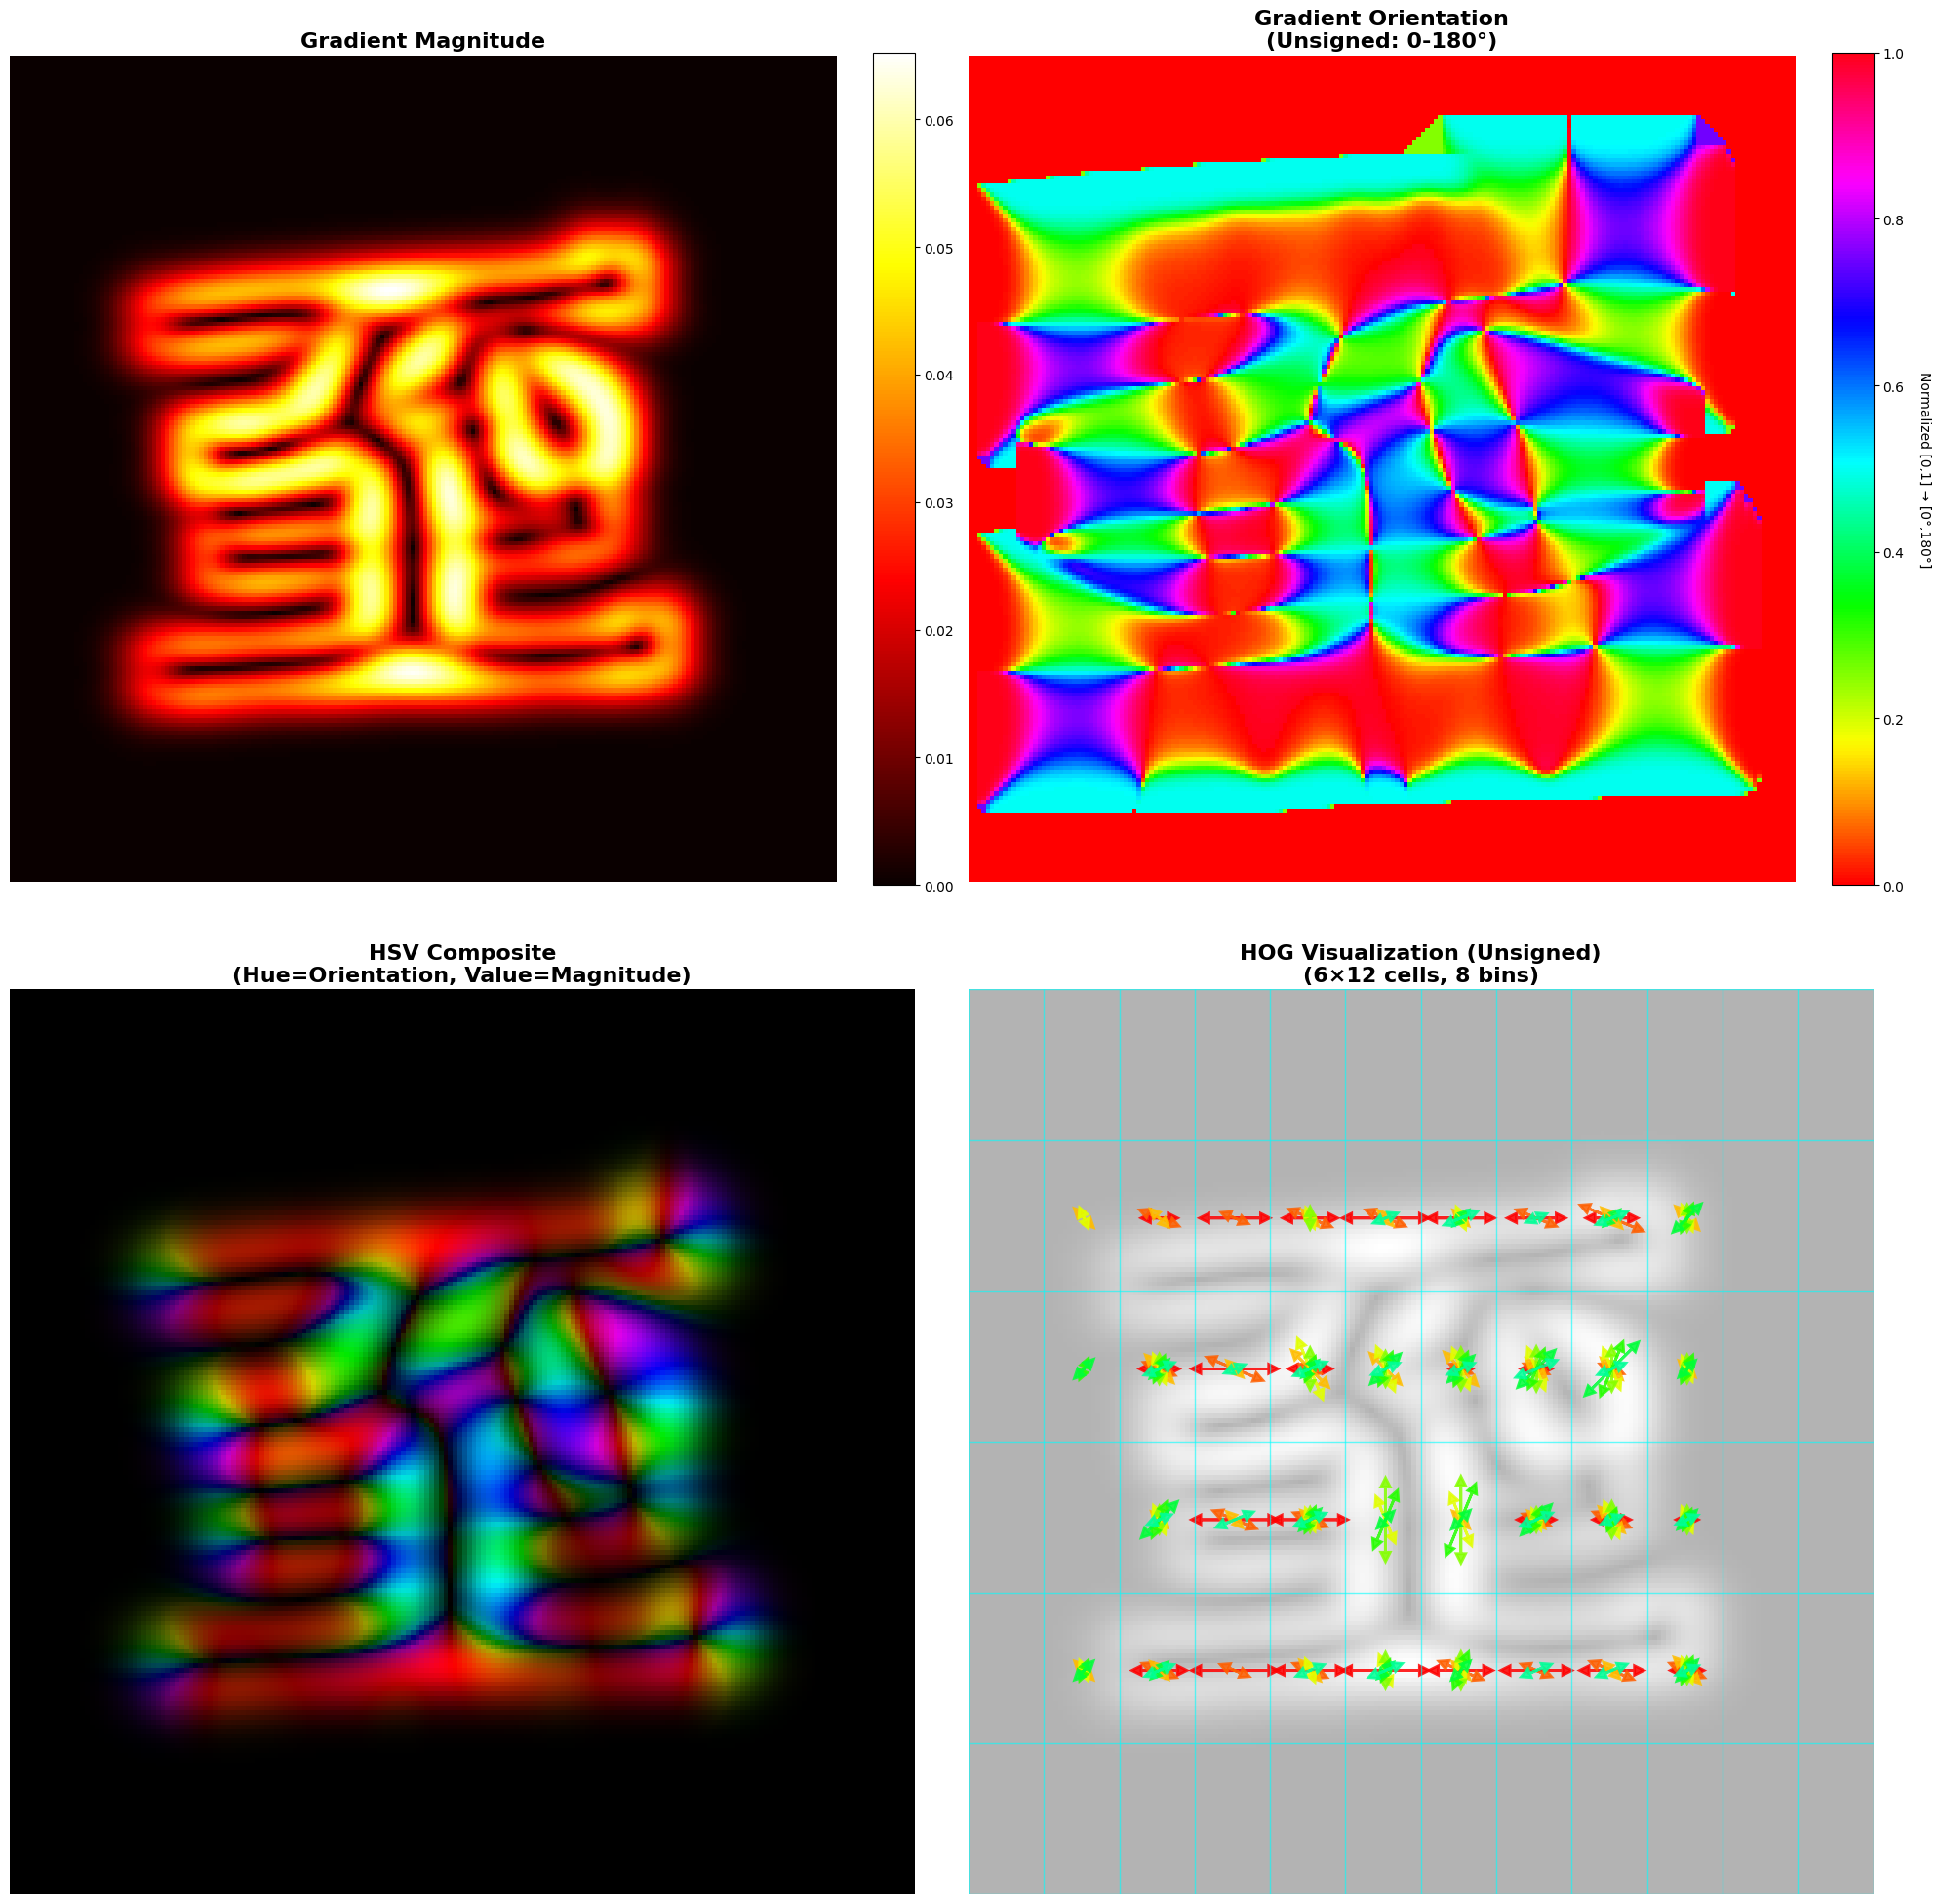


Histogram Statistics:
  Min: 0.0000
  Max: 0.2041
  Mean: 0.0184
  L2 norm: 1.0000


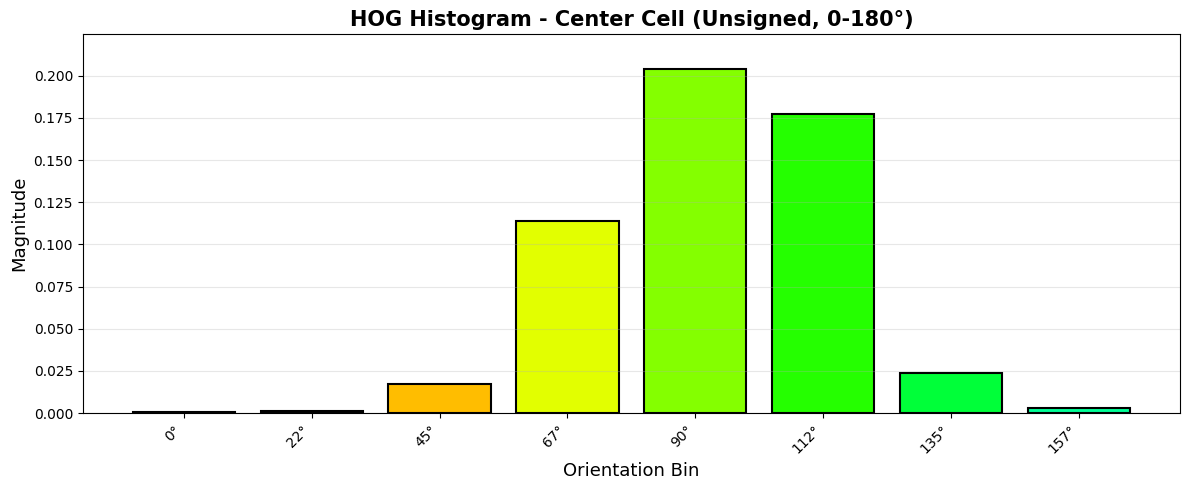

In [ ]:
i = np.random.randint(0, len(histograms_first_batch))
# i = 98
# i = 220

visualize_hog(hog_params, histograms_first_batch, first_batch, hogOutput, i)

In [ ]:
from src.character_linking.hog import HOG


first_batch = next(iter(dataloader))


hog = HOG(hog_params)

# Get the total number of samples and histogram shape
total_samples = len(dataloader.dataset)
sample_output = hog(first_batch[:1].unsqueeze(1).to(dtype=torch.float32, device='cuda'))
histogram_shape = sample_output.histograms[0, 0].shape

histograms = torch.zeros((total_samples, *histogram_shape), device='cuda')

# Fill progressively
start_idx = 0
for batch in tqdm(dataloader):
    hogOutput = hog(batch.unsqueeze(1).to(dtype=torch.float32, device='cuda'))
    histogram_batch = hogOutput.histograms[:, 0]
    
    batch_size = histogram_batch.shape[0]
    histograms[start_idx:start_idx + batch_size] = histogram_batch
    start_idx += batch_size


100%|██████████| 53/53 [01:42<00:00,  1.93s/it]


In [ ]:
patches_df['histogram'] = histograms.cpu().numpy()

**Let's look at a t-sne plot of the histograms to see if we can observe some clusters:**

In [ ]:
# X = patches_df['histogram'].reshape(histograms.shape[0], -1)[:10000]
# X.shape

# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, random_state=42)
# X_embedded = tsne.fit_transform(X)

# plt.figure(figsize=(10,10))
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=1)
# plt.xlabel('t-SNE 1')
# plt.ylabel('t-SNE 2')
# plt.title('t-SNE Plot')
# plt.show()


**We apply d-reduction to run our algorithms faster:**

In [ ]:
# X = rearrange(histograms.cpu(), 'B N_h N_b -> B (N_h N_b)')

# N_KEPT = 100

# from sklearn.decomposition import PCA
# pca = PCA(n_components=300)
# pca.fit(X)

# import matplotlib.pyplot as plt

# cum_var = pca.explained_variance_ratio_.cumsum()
# kept_var = cum_var[N_KEPT - 1]

# plt.figure(figsize=(8, 5))
# plt.stairs(cum_var, linewidth=2)
# plt.axhline(0.9, color='r', linestyle='--', alpha=0.5, label='90% variance')
# plt.axvline(N_KEPT, color='g', linestyle='--', alpha=0.5, 
#             label=f'{N_KEPT} components ({kept_var:.1%} var)')
# plt.axhline(kept_var, color='g', linestyle=':', alpha=0.3)
# plt.xlabel('N components')
# plt.ylabel('Cumulative explained variance')
# plt.title('PCA Explained Variance')
# plt.grid(alpha=0.3)
# plt.legend()
# plt.tight_layout()

# # Project onto N_KEPT components and reconstruct to original space
# X_reduced = pca.transform(X)[:, :N_KEPT]
# X_reconstructed = X_reduced @ pca.components_[:N_KEPT] + pca.mean_

# histograms = rearrange(torch.tensor(X_reconstructed), 'B (N_h N_b) -> B N_h N_b', 
#                        N_h=histograms.shape[1], N_b=histograms.shape[2]).to(device=histograms.device,dtype=histograms.dtype)

In [ ]:
# X = histograms.reshape(histograms.shape[0], -1).cpu().numpy()
# X.shape

# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, random_state=42)
# X_embedded = tsne.fit_transform(X)

# plt.figure(figsize=(15,15))
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=1)
# plt.xlabel('t-SNE 1')
# plt.ylabel('t-SNE 2')
# plt.title('t-SNE Plot')
# plt.show()


In [ ]:
# i = np.random.randint(0, len(histograms_first_batch))
# hog = HOG(hog_params)
# hogOutput = hog(first_batch.unsqueeze(1).to(dtype=torch.float32, device='cuda'))

# # visualize_hog(hog_params, histograms_first_batch, first_batch, hogOutput, i)

# X = rearrange(histograms_first_batch.cpu(), 'B N_h N_b -> B (N_h N_b)')
# X_reduced = pca.transform(X)[:, :N_KEPT]
# X_reconstructed = X_reduced @ pca.components_[:N_KEPT] + pca.mean_

# histograms_proj = rearrange(torch.tensor(X_reconstructed), 'B (N_h N_b) -> B N_h N_b', 
#                        N_h=histograms.shape[1], N_b=histograms.shape[2]).to(device=histograms.device,dtype=histograms.dtype)


# viz_only_hog(hog_params, histograms_first_batch, histograms_proj, img=first_batch[i], patch_idx=i)
# print('a')
# # visualize_hog(hog_params, histograms_proj, first_batch, hogOutput, i)


In [ ]:
patches_df.columns

Index(['bin_patch', 'img_patch', 'page', 'file', 'left', 'top', 'width',
       'height', 'svg', 'aspect_ratio', 'predicted_char', 'histogram'],
      dtype='object')

In [ ]:
# patches_df.columns['svg_column'] = df_copy['svg_column'].apply(lambda svg: svg.to_string())

In [ ]:
list(type(patches_df[col][0]) for col in patches_df.columns)

[numpy.ndarray,
 numpy.ndarray,
 int,
 str,
 int,
 int,
 int,
 int,
 src.patch_processing.svg.SVG,
 float,
 str,
 numpy.ndarray]

In [ ]:
patches_df['histogram'] = list(histograms.cpu().numpy())
from notebook_utils.parquet_utils import save_dataframe
save_dataframe(patches_df, 'data/processed/book1_columnwise')

Saving column: bin_patch
Saving column: img_patch
Saving column: page
Saving column: file
Saving column: left
Saving column: top
Saving column: width
Saving column: height
Saving column: svg
Saving column: aspect_ratio
Saving column: predicted_char
Saving column: histogram
✓ Saved to data/processed/book1_columnwise
